In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import gc

import tensorflow as tf
import keras
from keras import backend as K
from keras import layers
from keras.layers.core import Activation
from keras.utils.generic_utils import get_custom_objects

# from IPython.display import display
# pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', None)

In [2]:
# gpu_devices = tf.config.experimental.list_physical_devices('GPU')
# for device in gpu_devices:
#     tf.config.experimental.set_memory_growth(device, True)

### Reading data

Reading data from Parquet file. refer to Fast Data Loading and Low Mem with Parquet Files: https://www.kaggle.com/robikscube/fast-data-loading-and-low-mem-with-parquet-files

In [3]:
train = pd.read_parquet('../input/ubiquant-parquet/train_low_mem.parquet')

### Take a look at the data

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3141410 entries, 0 to 3141409
Columns: 304 entries, row_id to f_299
dtypes: float32(301), object(1), uint16(2)
memory usage: 3.6+ GB


You will find that row_id is of type string, time_id and investment_id are of type uint16, and others are of type float32.

In [5]:
def get_colums_by_dtype(df, dtype):
    s = (df.dtypes==dtype)
    return list(s[s].index)

print('object columns:', get_colums_by_dtype(train, 'object'))
print('object columns:', get_colums_by_dtype(train, 'uint16'))

object columns: ['row_id']
object columns: ['time_id', 'investment_id']


Because the dataset is so big, to save memory you can convert float32 to float16

In [6]:
for col in get_colums_by_dtype(train, 'float32'):
    train[col] = train[col].astype(np.float16)

### handling outliers

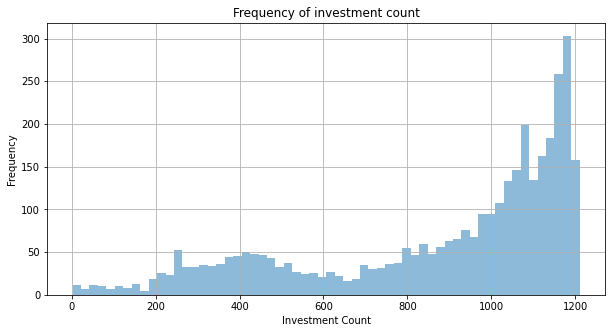

In [7]:
investment_count = train.groupby(['investment_id'])['target'].count()

investment_count.hist(bins=60, alpha = 0.5, figsize=(10, 5))
plt.xlabel('Investment Count')
plt.ylabel('Frequency')
plt.title('Frequency of investment count')
plt.grid(True)
plt.show()

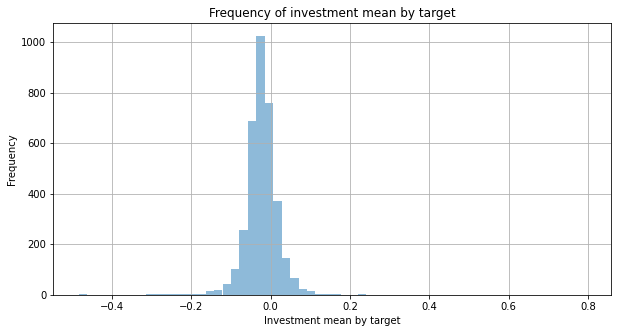

In [8]:
investment_mean = train.groupby(['investment_id'])['target'].mean()
investment_mean.hist(bins=60, alpha = 0.5, figsize=(10, 5))
plt.xlabel('Investment mean by target')
plt.ylabel('Frequency')
plt.title("Frequency of investment mean by target")
plt.grid(True)
plt.show()

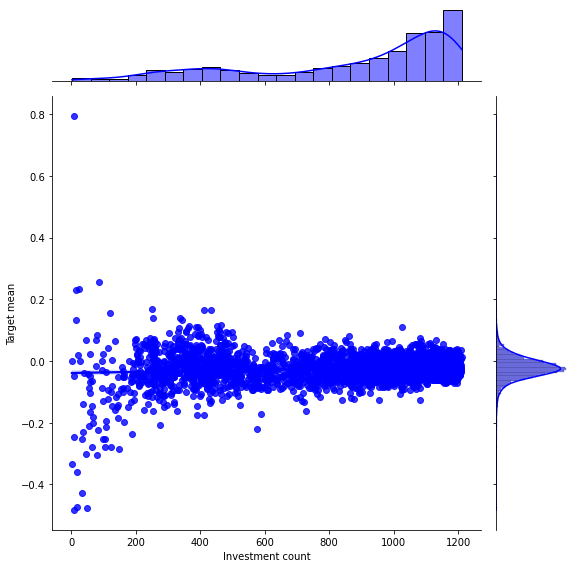

In [9]:
import seaborn as sns
ax = sns.jointplot(x=investment_count, y=investment_mean, kind='reg',height=8, color = 'blue')
ax.ax_joint.set_xlabel('Investment count')
ax.ax_joint.set_ylabel('Target mean')
plt.show()

In [10]:
outlier_investment = investment_mean[abs(investment_mean)>0.4].index.tolist()
X = train[~train['investment_id'].isin(outlier_investment)]

In [11]:
del train
del investment_mean
del investment_count
del outlier_investment
gc.collect()

13240

In [12]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3141294 entries, 0 to 3141409
Columns: 304 entries, row_id to f_299
dtypes: float16(301), object(1), uint16(2)
memory usage: 1.8+ GB


### Splitting data

How to split X into train set and test set, generally you can do like this: 

In [13]:
# y = X.pop("target")
# _ = X.pop('row_id')
# from sklearn.model_selection import train_test_split
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
# # X_train, y_train, X_test, y_test = X[0:2122479], y[0:2122479], X[2122479:], y[2122479:]

However, if you want to achieve better prediction, maybe you need to consider the distribution of time_id and investment_id. Let's take a look at their hist diagrams.

<function matplotlib.pyplot.show(close=None, block=None)>

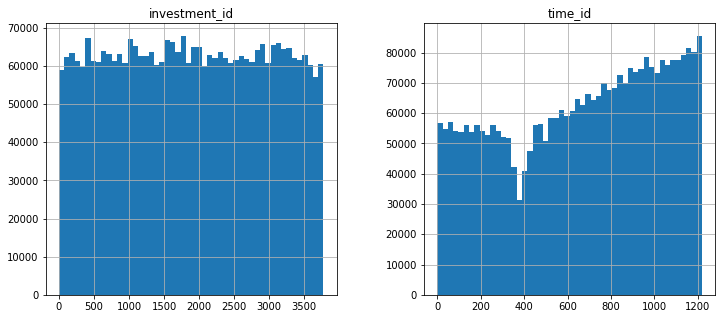

In [14]:
X[['investment_id', 'time_id']].hist(bins=50, figsize=(12,5))
plt.show

You can see from the above that the distribution of investment_id is relatively uniform, while the time_id is distributed incrementally. In order to prevent sampling bias, We will split data based on time_id by using stratified sampling.

In [15]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_index, test_index = list(split.split(X, X['time_id']))[0]

In [16]:
X_train = X.iloc[train_index]
X_test = X.iloc[test_index]

In [17]:
del X
gc.collect()

12209

Verify the sampling result。

In [18]:
display(X_train['time_id'].value_counts() / len(X_train))
display(X_test['time_id'].value_counts() / len(X_test))

1214    0.001095
1209    0.001095
1207    0.001094
1211    0.001094
1208    0.001093
          ...   
415     0.000210
362     0.000207
374     0.000191
398     0.000172
492     0.000163
Name: time_id, Length: 1211, dtype: float64

1214    0.001095
1207    0.001095
1209    0.001095
1212    0.001093
1213    0.001093
          ...   
415     0.000210
362     0.000207
374     0.000191
398     0.000172
492     0.000162
Name: time_id, Length: 1211, dtype: float64

In [19]:
y_train = X_train.pop('target')
y_test = X_test.pop('target')
_ = X_train.pop('row_id')
X_train_time_id = X_train.pop('time_id')
_ = X_test.pop('row_id')
X_test_time_id = X_test.pop('time_id')

In [20]:
print(X_train.info())
print(X_test.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2513035 entries, 2977773 to 1444946
Columns: 301 entries, investment_id to f_299
dtypes: float16(300), uint16(1)
memory usage: 1.4 GB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 628259 entries, 2313954 to 46166
Columns: 301 entries, investment_id to f_299
dtypes: float16(300), uint16(1)
memory usage: 365.5 MB
None


Making dataset for multiple input models

In [21]:
def make_dataset(investment_id, features, y=None, batch_size=1024):
    if y is not None:
        slices = ((investment_id, features), y)
    else:
        slices = ((investment_id, features))
        
    ds = tf.data.Dataset.from_tensor_slices(slices)
    ds = ds.batch(batch_size).cache().prefetch(tf.data.experimental.AUTOTUNE)
    
    return ds

### Building models
#### Define models

In [22]:
def get_model(hidden_layer_nodes=[256, 128, 32], activation='swish', batchNormalization=True, dropOut=None):
    model = keras.Sequential()
    if not batchNormalization:
        batchNormalization = False
    if not isinstance(batchNormalization, list):
        batchNormalization = [batchNormalization] * len(hidden_layer_nodes)
    if not dropOut:
        dropOut = 0.0
    if not isinstance(dropOut, list):
        dropOut = [dropOut] * len(hidden_layer_nodes)
    for node_num,bn,dropout_rate in zip(hidden_layer_nodes, batchNormalization, dropOut):
        model.add(keras.layers.Dense(node_num))
        if bn:
            model.add(keras.layers.BatchNormalization())
        model.add(keras.layers.Activation(activation)) 
        if dropout_rate>0:
            model.add(keras.layers.Dropout(dropout_rate)) 
            

    # Add activation function to classifier
    model.add(keras.layers.Dense(1, activation='linear'))

    rmse = tf.keras.metrics.RootMeanSquaredError(name="rmse")

    model.compile(loss="mean_squared_error", optimizer="adam", metrics=["mse", rmse])
    #model.compile(optimizer=tf.optimizers.Adam(0.001), loss='mse', metrics=['mse', rmse])
    return model

In [23]:
def get_multi_input_model():
    investment_id_input = tf.keras.Input(shape=(1,), dtype=tf.uint16, name='investment_id')
    investment_id_x = layers.Dense(64, activation='relu')(investment_id_input)

    features_input = tf.keras.Input(shape=(300,), dtype=tf.float16, name='features')
    features_x = layers.Dense(512, activation='swish')(features_input)
    features_x = layers.Dense(256, activation='swish')(features_x)


    concatenated = layers.concatenate([investment_id_x, features_x], axis=-1)
    mixed_x = layers.Dense(32, activation='relu')(concatenated)
    output = layers.Dense(1)(mixed_x)

    model = keras.models.Model([investment_id_input, features_input], output, name='model_with_multi_input')
    rmse = tf.keras.metrics.RootMeanSquaredError(name="rmse")
    model.compile(optimizer='adam', loss='mse', metrics=['mse', rmse])
    
    return model

### First: A basic model

In [ ]:
mc = keras.callbacks.ModelCheckpoint("best_model_basic.h5", monitor="val_mse", save_best_only=True, mode="min", verbose=1)
model=get_model(activation='swish')
model.fit(X_train, y_train, epochs=15, validation_data=(X_test, y_test), callbacks=[mc])

### Second: A basic model with early stop callback

In [ ]:
es = keras.callbacks.EarlyStopping(monitor="val_mse", patience=4, mode="min")
mc = keras.callbacks.ModelCheckpoint("best_model_basic_with_early_stop.h5", monitor="val_mse", save_best_only=True, mode="min", verbose=1)
model=get_model(activation='swish')
model.fit(X_train, y_train, epochs=50, validation_data=(X_test, y_test), callbacks=[es, mc])

### Third: Model with custom defined activation

In [60]:
def custom_activation(x):
  
    #return (1/(1 + K.exp(-x)))
    return K.sin(math.pi * x /2)
     
#get_custom_objects().update({'custom_activation': Activation(custom_activation)})

In [61]:
# es = keras.callbacks.EarlyStopping(monitor="val_mse", patience=4, mode="min")
mc = keras.callbacks.ModelCheckpoint("best_model_with_custom_activation.h5", monitor="val_mse", save_best_only=True, mode="min", verbose=1)
model=get_model(activation=custom_activation)
model.fit(X_train, y_train, epochs=15, validation_data=(X_test, y_test), callbacks=[mc])

2022-04-19 05:03:44.043481: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 3025694140 exceeds 10% of free system memory.


Epoch 1/2
78533/78533 [==============================] - 345s 4ms/step - loss: 0.8401 - mse: 0.8401 - rmse: 0.9166 - val_loss: 0.8301 - val_mse: 0.8301 - val_rmse: 0.9111

Epoch 00001: val_mse improved from inf to 0.83012, saving model to best_model_with_custom_activation.h5
Epoch 2/2
78533/78533 [==============================] - 341s 4ms/step - loss: 0.8356 - mse: 0.8356 - rmse: 0.9141 - val_loss: 0.8336 - val_mse: 0.8336 - val_rmse: 0.9130

Epoch 00002: val_mse did not improve from 0.83012


### Forth: Model with multiple inputs

Like BERT, the investment_id here is encoded separately.

In [ ]:
investment_id = X_train.pop('investment_id')
train_ds = make_dataset(investment_id=investment_id, features=X_train, y=y_train)
val_investment_id = X_test.pop('investment_id')

In [ ]:
model = get_multi_input_model()
tf.keras.utils.plot_model(model, show_shapes=True)
mc = keras.callbacks.ModelCheckpoint("best_model_with_multi_input.h5", monitor="val_mse", save_best_only=True, mode="min", verbose=1)

In [ ]:
model.fit(train_ds, validation_data=((val_investment_id, X_test), y_test), epochs=15, callbacks=[mc])

### Making prediction and Submitting result

We found that the best model is best_model_with_custom_activation.h5. so we will use this model to make prediction as our submission.

In [30]:
df_test = pd.read_parquet('../input/ubiquant-parquet/example_test.parquet')

In [31]:
sample_prediction_df = df_test[['row_id','time_id']]

In [32]:
df_test.drop(['row_id','time_id'],axis=1,inplace=True)

In [62]:
custom_objects = {"custom_activation": custom_activation}
model = keras.models.load_model('best_model_with_custom_activation.h5',compile=True, custom_objects= custom_objects)
preds = model.predict(df_test)

In [64]:
sample_prediction_df = pd.concat([sample_prediction_df,pd.DataFrame(preds, columns=['target'])], axis=1)

In [65]:
sample_prediction_df.head()

,row_id,time_id,target,target
0,1220_1,1220,0.068571,0.068571
1,1220_2,1220,0.126726,0.126726
2,1221_0,1221,0.089674,0.089674
3,1221_1,1221,0.101767,0.101767
4,1221_2,1221,0.099409,0.099409


In [66]:
sample_prediction_df.to_csv('submission_sample_prediction_df.csv')